# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

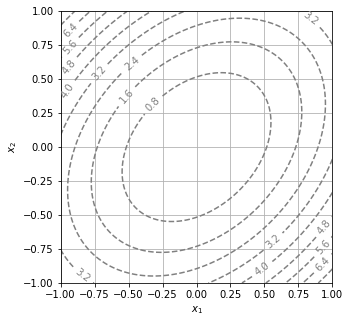

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

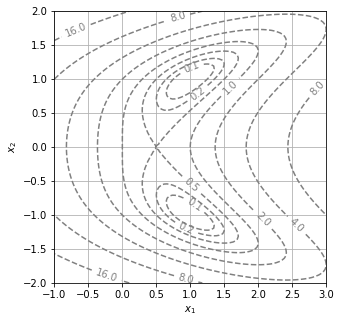

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

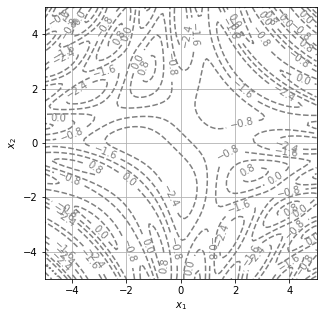

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 1000
eps = 10**-14

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
    J_F=J(F)
    for i in range(N):
        x,y=(x0,y0)-np.dot(np.linalg.inv(J_F(x0,y0)),F(x0,y0))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y

    raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [15]:
def g(x,y):
    return np.array([f1(x,y)-0.8,x-y])

x,y = Newton(g, 0.8, 0.8, eps,N)
#f1(1,1)
x,y

(0.4472135954999579, 0.4472135954999579)

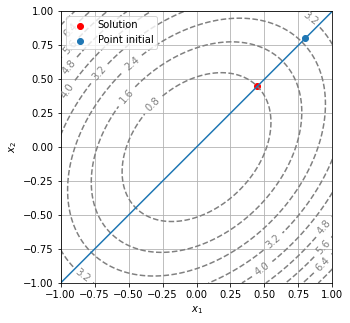

In [16]:
def fond() :
    display_contour(
        f1, 
        x=np.linspace(-1.0, 1.0, 100), 
        y=np.linspace(-1.0, 1.0, 100), 
        levels=10 # 10 levels, automatically selected
    )
    x=np.linspace(-1.0, 1.0, 100)
    y=np.linspace(-1.0, 1.0, 100)
    plt.plot(x,y)
#point initial 0.8,0.8
fond()
plt.scatter(Newton(g,0.8,0.8)[0],Newton(g,0.8,0.8)[1], c='red', label="Solution")
plt.scatter(0.8,0.8, label="Point initial")
plt.legend()

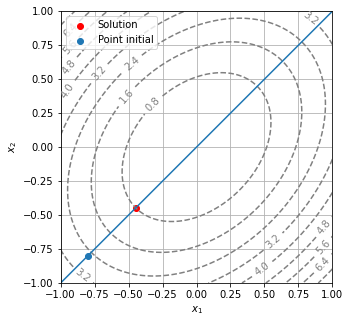

In [17]:
#point intial (-0.8,-0.8)
fond()
plt.scatter(Newton(g,-0.8,-0.8)[0],Newton(g,-0.8,-0.8)[1], c='red',label = "Solution")
#logiquement ici l'algorithme va être "attirée " vers le point le plus proche
#il semblerait que si le point initial est dans la partie inférieure gauche (vérifiant x+y<0) , la méthode va renvoyer
#ce même point. C'est l'inverse pour la zone x+y>0. Et sur la frontière (x=-y), la méthode ne fonctionne pas.
plt.scatter(-0.8,-0.8,label="Point initial")
plt.legend()

Singular matrix


"Et sur la frontière (x=-y), la méthode ne fonctionne pas car le déterminant de la matrice jacobienne de F1 sur l'antidiagonale est toujours nul "

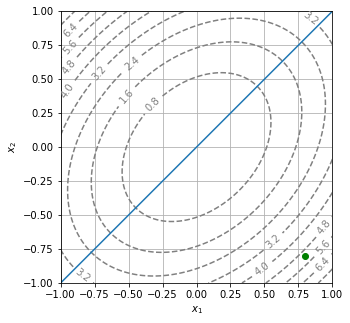

In [18]:
#point intial (0.8,-0.8)
fond()
try : 
    plt.scatter(0.8,-0.8,c='green')
    plt.scatter(Newton(g,-0.8,0.8)[0],Newton(F1,-0.8,0.8)[1], c='red')
except np.linalg.LinAlgError as err:
    print(err)
"""Et sur la frontière (x=-y), la méthode ne fonctionne pas car le déterminant de la matrice jacobienne de F1 sur l'antidiagonale est toujours nul """


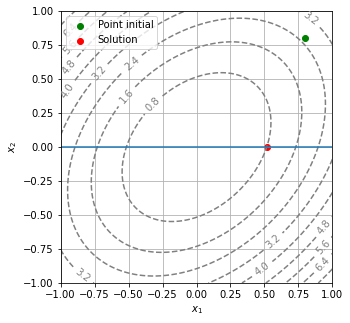

In [19]:
# on change la contrainte : on veut maintenant trouver un point sur la ligne de niveau vérifiant y=0
def F1_bis(x,y) :
    return np.array([f1(x,y)-0.8,y])

display_contour(
        f1, 
        x=np.linspace(-1.0, 1.0, 100), 
        y=np.linspace(-1.0, 1.0, 100), 
        levels=10 # 10 levels, automatically selected
    )
x=np.linspace(-1.0, 1.0, 100)
plt.plot(x,np.zeros(100,))
plt.scatter(0.8,0.8,c='green',label="Point initial")
plt.scatter(Newton(F1_bis,0.8,0.8)[0],Newton(F1_bis,0.8,0.8)[1], c='red', label="Solution")
plt.legend()

In [20]:
#si on prend la contrainte y=1, évidemment, la méthode ne converge pas
def F1_ter(x,y) :
    return np.array([f1(x,y)-0.8,y-1])

try :
    Newton(F1_ter,0.8,0.8)
except ValueError as err:
    print(err)

no convergence in 1000 steps.


### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

(-1.0, 1.0)

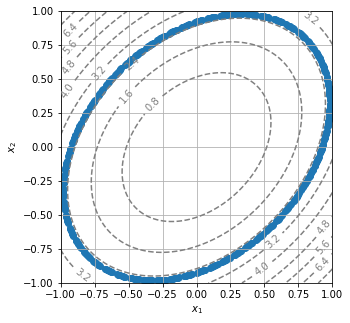

In [21]:
def level_curve(f, x0, y0, delta=0.1, N=500, eps=eps):
    c=f(x0,y0)
    grad_f = grad(f)
    Tab = [[x0,y0]]
    xref,yref = x0,y0
    for i in range(N):
        gradient_0 = grad_f(xref,yref)
        X_i = np.array([gradient_0[1], -gradient_0[0]])
        X_i = X_i / np.linalg.norm(X_i) * delta
        def g(x,y):
            return np.array([f(x,y)-c,(x-xref)**2+(y-yref)**2 - delta**2])
        x1,y1 = Newton(g,X_i[0]+xref,X_i[1]+yref,eps,100)
        Tab.append([x1,y1])
        xref,yref = x1,y1
    return np.array(Tab)

display_contour(
        f1, 
        x=np.linspace(-1.0, 1.0, 100), 
        y=np.linspace(-1.0, 1.0, 100), 
        levels=10 # 10 levels, automatically selected
    )

Tab = level_curve(f1,0.8,0.8)
plt.scatter(Tab[:,0],Tab[:,1])
plt.xlim([-1,1])
plt.ylim([-1,1])

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

(-1.0, 1.0)

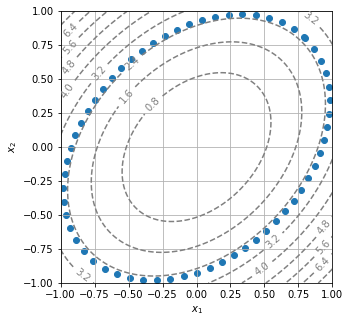

In [22]:
def level_curve2(f, x0, y0, delta=0.1, eps=eps):
    c=f(x0,y0)
    grad_f = grad(f)
    Tab = [[x0,y0]]
    xref, yref = x0, y0
    while True :
        gradient_0 = grad_f(xref,yref)
        X_i = np.array([gradient_0[1], -gradient_0[0]])
        X_i = X_i / np.linalg.norm(X_i) * delta
        def g(x,y):
            return np.array([f(x,y)-c,(x-xref)**2+(y-yref)**2 - delta**2])
        x1,y1 = Newton(g,X_i[0]+xref,X_i[1]+yref,eps,1000)
        Tab.append([x1,y1])
        xref,yref = x1,y1
        # Pour arrêter le bouclage :
        if np.sqrt((Tab[0][0]-xref)**2+(Tab[0][1]-yref)**2) < delta/2 :
            return np.array(Tab)

        
display_contour(
        f1, 
        x=np.linspace(-1.0, 1.0, 100), 
        y=np.linspace(-1.0, 1.0, 100), 
        levels=10 # 10 levels, automatically selected
    )

Tab = level_curve2(f1,0.8,0.8)
plt.scatter(Tab[:,0],Tab[:,1])
plt.xlim([-1,1])
plt.ylim([-1,1])

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

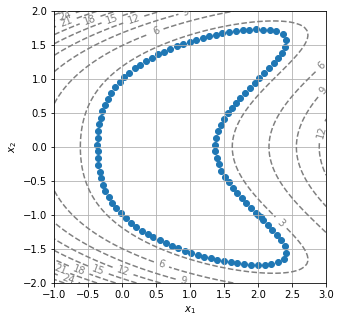

In [23]:
display_contour(
        f2, 
        x=np.linspace(-1., 3., 100), 
        y=np.linspace(-2., 2., 100), 
        levels=10 # 10 levels, automatically selected
    )

Tab = level_curve2(f2,2.,-1.)
plt.scatter(Tab[:,0],Tab[:,1])
plt.xlim([-1,3])
plt.ylim([-2,2])
plt.show()

(-2.0, 0.0)

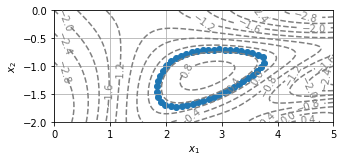

In [24]:
display_contour(
        f3, 
        x=np.linspace(0., 5., 100), 
        y=np.linspace(-2., 0., 100), 
        levels=10 # 10 levels, automatically selected
    )
Tab = level_curve2(f3,2.,-1.)
plt.scatter(Tab[:,0],Tab[:,1])
plt.xlim([0,5])
plt.ylim([-2,0])

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [ ]:
def area_squares(f,c,h):
    def F(x,y):
        return np.array([f(x,y)-c,x-y]) 
    x0,y0=Newton(F, 1.0, 1.0, eps=eps, N=N)
    points=level_curve2(f, float(x0), float(y0))
    diametre=0
    for k in range(len(points)):
        for i in range(len(points)):
            if np.linalg.norm(points[k]-points[i])>diametre :
                diametre=np.linalg.norm(points[k]-points[i])
    
    
    x,y=points[0,:] #centre du carré de côté 2*diametre
    nbr_carre=0
    indice=int(np.floor(diametre/h)) # nombre de mini carrés = indice^2
    for i in range(-indice,indice): # on regarde si le sens des mini carrés est dans l'ensemble de sous niveau ou non
        for j in range (-indice,indice):
            if f(float(x+i*h),float(y+j*h))<=c:
                nbr_carre+=1
    
    return nbr_carre*h**2

def cercle(x,y):
    return (x**2+y**2)


area_vec=np.vectorize(area_squares)

def erreur() :
    x=np.logspace(-3,0,20)
    print(x)
    y=area_vec(cercle,1.0,x)-np.pi
    print(y)
    plt.loglog(x,abs(y))
    plt.loglog(x,x**2)
    plt.show()
    
erreur()

[1.00000000e-04 1.37382380e-04 1.88739182e-04 2.59294380e-04
 3.56224789e-04 4.89390092e-04 6.72335754e-04 9.23670857e-04
 1.26896100e-03 1.74332882e-03 2.39502662e-03 3.29034456e-03
 4.52035366e-03 6.21016942e-03 8.53167852e-03 1.17210230e-02
 1.61026203e-02 2.21221629e-02 3.03919538e-02 4.17531894e-02
 5.73615251e-02 7.88046282e-02 1.08263673e-01 1.48735211e-01
 2.04335972e-01 2.80721620e-01 3.85662042e-01 5.29831691e-01
 7.27895384e-01 1.00000000e+00]


**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [52]:
"""cette fois ci au lieu de regarder si le centre du petit carré est dans l'ensemble, on vérifie si c'est 4 coins sont
dans l'ensemble. Si l'ensemble de sous niveau est convexe, ça suffit pour affirmer que l'intégralité du carré est 
dans l'ensemble. """
def encadrement(f,c,h) :
    def F(x,y):
        return np.array([f(x,y)-c,x-y]) 
    x0,y0=Newton(F, 1.0, 1.0, eps=eps, N=N)
    points=level_curve2(f, float(x0), float(y0))
    diametre=0
    for k in range(len(points)):
        for i in range(len(points)):
            if np.linalg.norm(points[k]-points[i])>diametre :
                diametre=np.linalg.norm(points[k]-points[i])
    
    
    x,y=points[0,:] #centre du carré de côté 2*diametre
    nbr_carre=0
    nbr_carre_interieur=0
    indice=int(np.floor(diametre/h)) # nombre de mini carrés = indice^2
    for i in range(-indice,indice): # on regarde si le sens des mini carrés est dans l'ensemble de sous niveau ou non
        for j in range (-indice,indice):
            if f(float(x+i*h),float(y+j*h))<=c:
                nbr_carre+=1
                if f(x+i*h+h/2,y+j*h+h/2)<=c and f(x+i*h-h/2,y+j*h+h/2)<=c and f(x+i*h+h/2,y+j*h-h/2)<=c and f(x+i*h-h/2,y+j*h-h/2)<=c :
                    nbr_carre_interieur+=1
    return (nbr_carre_interieur*h**2,nbr_carre*h**2)

def cercle(x,y):
    return (x**2+y**2)

encadrement(cercle,1,0.01)

(3.1016000000000004, 3.1416)

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [38]:
def cercle_u(delta): #Génération des points de la frontière du cercle unité
    X = np.arange(0,2*np.pi,delta)
    return np.array([[np.cos(a),-1*np.sin(a)] for a in X]) #Signe -1 pour être dans le sens anti-trigonométrique

def aire_cercle_u(delta, p):
    frontiere = cercle_u(delta)
    aire = 0
    n = len(frontiere)
    pa = np.array(p)
    for i in range(n-1):
        u,v = frontiere[i+1]-pa, frontiere[i]-pa
        aire += np.linalg.det((u,v))/2
    u,v = frontiere[0]-pa, frontiere[-1]-pa #Dernier calcul d'aire pour "boucler la boucle"
    aire += np.linalg.det((u,v))/2
    return aire

BN = aire_cercle_u(0.001,[0,0])
BN  #On retrouve bien : BN ~= 3.141592

3.1415921300058978

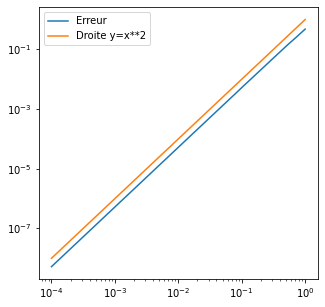

In [49]:
#Vitesse de convergence :
DELTA = np.logspace(-4,0,50)
Err = [np.abs(aire_cercle_u(delta, [0,0])-np.pi) for delta in DELTA]
plt.loglog(DELTA,Err, label="Erreur")
plt.loglog(DELTA,DELTA**2, label="Droite y=x**2")
plt.legend()

##On observe une convergence d'ordre 2

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [41]:
Liste = [[23,2],[-4,-37],[1,-1],[6,-9],[0,0]] #Liste de points en dehors de K
for point in Liste :
    BN = aire_cercle_u(0.0001,point)
    print(BN)
    
#Les résultats sont pertinents. En effet, quel que soit le point de référence p,
#??

3.1415926483540333
3.1415926483540395
3.141592648353829
3.1415926483539915
3.1415926483512426


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [50]:
C1 = cercle_u(0.0001)
C2 = C1 + 3 # On a alors 2 disques disjoints
Liste = np.concatenate((C1,C2)) #Liste des points de l'ensemble K non convexe

aire = 0
n = len(Liste)
pa = np.array([0,0])
for i in range(n-1):
    u,v = Liste[i+1]-pa, Liste[i]-pa
    aire += np.linalg.det((u,v))/2
u,v = Liste[0]-pa, Liste[-1]-pa
aire += np.linalg.det((u,v))/2
print(aire) #On a bien 3.1415 * 2

6.28318529670517


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [29]:
def area_triangles(x,y):
    

#La méthode des carrés est plus coûteuse en calculs car pour un écart h entre les points,
#la fonction est en O(1/h^2) tandis que la complexité est de O(1/delta) pour la méthode des triangles.
#h et delta étant comparables car ils déterminent l'écart entre chaque point considéré.
#En effet, la méthode des carrés met beaucoup plus de temps à s'exéctuer.
#